Скаченный датасет с kaggle https://www.kaggle.com/datasets/yashdogra/insectv2-dataset

Классы в наборе данных (пример)

Тли (Aphids) – Вредители, высасывающие сок растений, что ослабляет их.

Жуки (Beetles) – Разнообразная группа насекомых, некоторые из которых вредят урожаю.

Гусеницы (Caterpillars) – Личинки бабочек и мотыльков, которые питаются листьями.

Кузнечики (Grasshoppers) – Известны тем, что вызывают дефолиацию (объедание листьев) у растений.

Цикадки (Leafhoppers) – Насекомые, которые распространяют болезни растений через питание.

Белокрылки (Whiteflies) – Мелкие насекомые, которые повреждают растения, высасывая сок.

Трипсы (Thrips) – Мелкие вредители, наносящие значительный ущерб цветам и овощам.

Долгоносики (Weevils) – Насекомые, которые поражают хранящееся зерно и урожай.

Мотыльки (Moths) – Некоторые виды откладывают яйца на растения, что приводит к появлению гусениц.

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

In [16]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [17]:
import kagglehub

# Download latest version
fpath = kagglehub.dataset_download("yashdogra/insectv2-dataset")

print("Path to dataset files:", fpath)

Path to dataset files: /root/.cache/kagglehub/datasets/yashdogra/insectv2-dataset/versions/2


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
# Загрузим предварительно обученную модель ResNet18
model = models.resnet18(pretrained=True)

# Заменим последний слой (fully connected) так, чтобы количество выходных каналов соответствовало 3 классам
num_classes = 9
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
import torch

from torch.utils.data import DataLoader, random_split

# Определим пути к данным
train_data_dir = fpath + '/pest/train'
test_data_dir = fpath + '/pest/test'

# Определим трансформации
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
test_dataset = ImageFolder(test_data_dir, transform=test_transforms)
train_classes = train_dataset.classes
test_classes = test_dataset.classes
# Разделим тренировочный набор на тренировочный и валидационный
train_size = int(0.8 * len(train_dataset))  # 80% данных для тренировки
val_size = len(train_dataset) - train_size  # 20% данных для валидации
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Теперь у вас есть три загрузчика данных:
# train_loader - для тренировочных данных
# val_loader - для валидационных данных
# test_loader - для тестовых данных

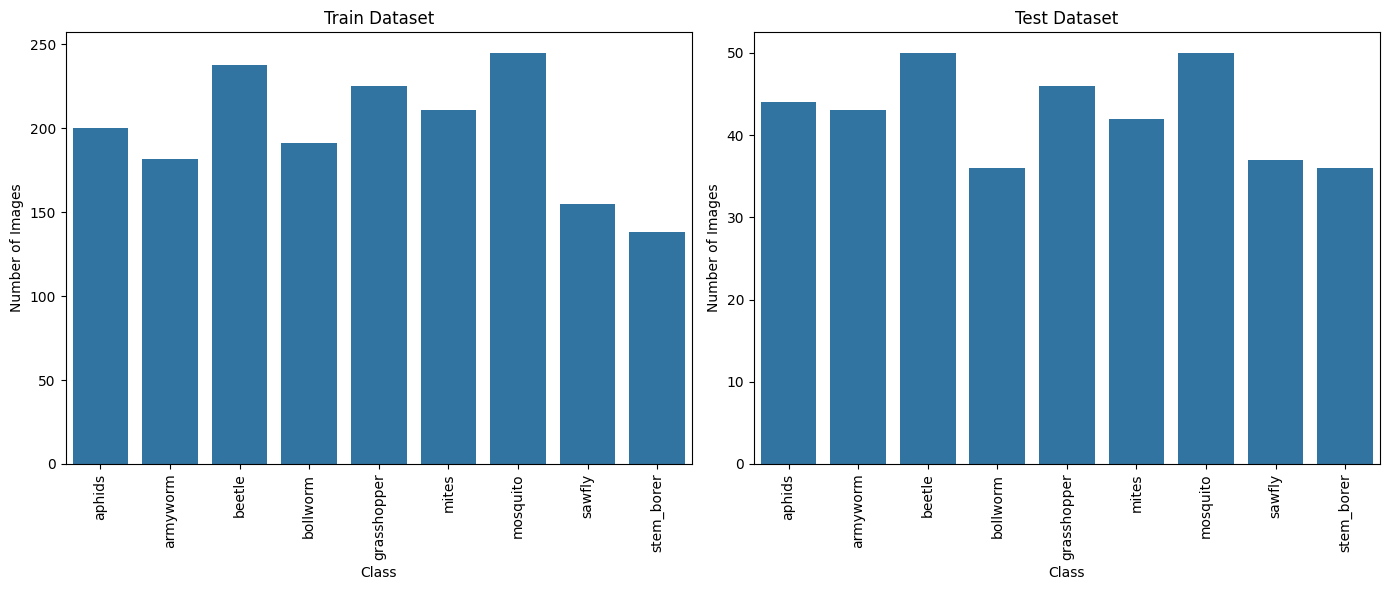

In [21]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
test_class_counts = np.zeros(len(test_classes))
for _, label in test_dataset:
    test_class_counts[label] += 1

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для train
sns.barplot(x=train_classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для test
sns.barplot(x=test_classes, y=test_class_counts, ax=ax[1])
ax[1].set_title('Test Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [22]:
# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# число эпох
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Сохранение лучшей модели на основе валидационной точности
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

print('Training and validation complete!')

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [1/10], Train Loss: 1.0497, Train Accuracy: 0.6952, Val Loss: 0.3582, Val Accuracy: 0.9128
Saved best model!



100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Epoch [2/10], Train Loss: 0.1906, Train Accuracy: 0.9759, Val Loss: 0.0974, Val Accuracy: 0.9911
Saved best model!



100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch [3/10], Train Loss: 0.0557, Train Accuracy: 0.9966, Val Loss: 0.0359, Val Accuracy: 0.9978
Saved best model!



100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Epoch [4/10], Train Loss: 0.0282, Train Accuracy: 0.9978, Val Loss: 0.0246, Val Accuracy: 0.9955



100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [5/10], Train Loss: 0.0144, Train Accuracy: 0.9989, Val Loss: 0.0150, Val Accuracy: 0.9978



100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Epoch [6/10], Train Loss: 0.0113, Train Accuracy: 0.9994, Val Loss: 0.0103, Val Accuracy: 0.9978



100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch [7/10], Train Loss: 0.0107, Train Accuracy: 0.9989, Val Loss: 0.0101, Val Accuracy: 1.0000
Saved best model!



100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch [8/10], Train Loss: 0.0084, Train Accuracy: 0.9989, Val Loss: 0.0090, Val Accuracy: 0.9978



100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch [9/10], Train Loss: 0.0059, Train Accuracy: 1.0000, Val Loss: 0.0077, Val Accuracy: 0.9978



100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

Epoch [10/10], Train Loss: 0.0053, Train Accuracy: 0.9994, Val Loss: 0.0081, Val Accuracy: 0.9978

Training and validation complete!


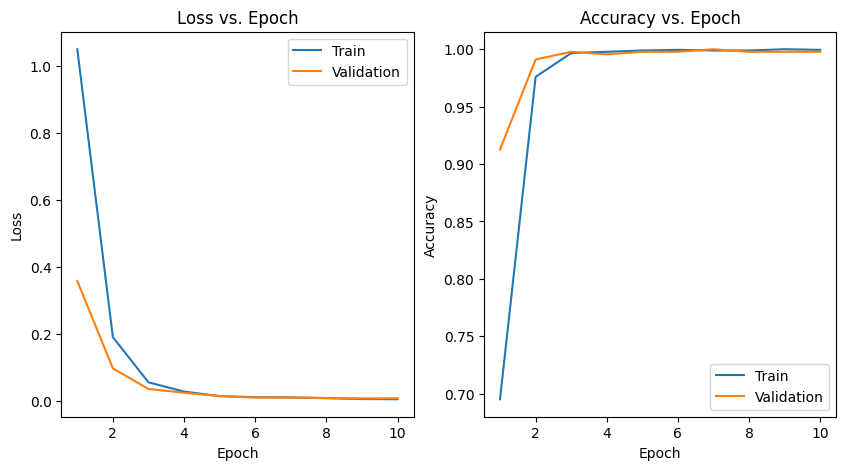

In [23]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [24]:
# Получение метрик качества для текущих весов модели
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Функция для построения графика матрицы ошибок
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       1.00      0.98      0.99        43
           2       0.98      1.00      0.99        50
           3       0.97      1.00      0.99        36
           4       0.98      1.00      0.99        46
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00        50
           7       1.00      0.92      0.96        37
           8       0.97      0.97      0.97        36

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384

Test Accuracy: 0.9870


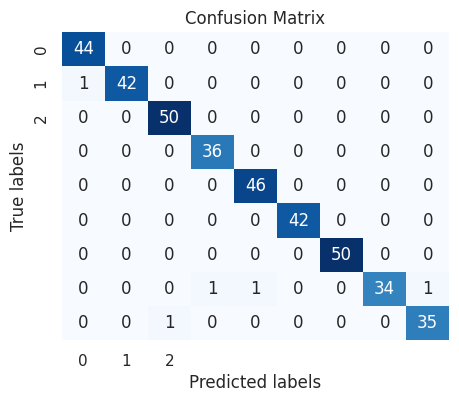

In [25]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))